In [125]:
### IMPORTS ###
from bath_constants import (
    Boltzmann,
    hbar,
    ############## Bath parameters ##############
)
# functions from test_baths.py
from test_baths import (
    spectral_density_func_ohmic,
    spectral_density_func_drude_lorentz,
)
import matplotlib.pyplot as plt
from qutip import *
import numpy as np

from qutip.solver.heom import (
    DrudeLorentzBath,
    HEOMSolver,
    heomsolve,
)

# Import the outsourced plot settings
from plot_settings import *

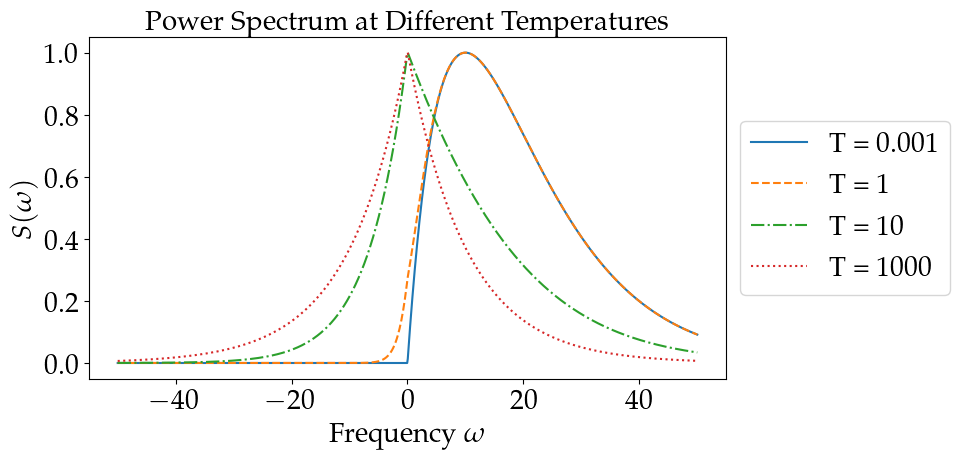

In [126]:
# =============================
# PLOT BATH MODEL FOR MULTIPLE TEMPERATURES
# =============================
def create_bath_model(eta, cutoff, Temp):
    """
    Create a bath model using the given parameters.

    Parameters:
    eta (float): Coupling strength to the bath.
    cutoff (float): Cutoff frequency of the bath model.
    Temp (float): Temperature of the system.

    Returns:
    bath_model: Spectral density of the bath.
    """
    args_ohmic = {"eta": eta, "cutoff": cutoff, "s": 1.0} # define bath parameters
    args_dl    = {"lambda": eta * cutoff / 2, "cutoff":cutoff} 
    bath_args  = args_ohmic

    """env = OhmicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, bath_args),
        wMax=10 * cutoff,
        T=Temp
    )"""
    env = OhmicEnvironment(T=Temp, alpha=eta, wc=cutoff, s=bath_args["s"])

    return lambda w: env.power_spectrum(w)

# Define temperatures to evaluate
temperatures = [1e-3, 1, 10, 1000]
cutoff_test, gamma_test = 10, 10
frequencies = np.linspace(-5 * cutoff_test, 5 * cutoff_test, 1000)

# Initialize the plot
plt.figure(figsize=(10, 5))

# Loop through temperatures and plot the spectral density
for idx, T in enumerate(temperatures):
    power_spectrum = create_bath_model(gamma_test, cutoff_test, T)  # Call the function
    spectral_values  = [power_spectrum(w) for w in frequencies]  # Evaluate spectral density

    # Plot the spectral density
    plt.plot(
        frequencies, 
        spectral_values / np.max(np.abs(spectral_values)), 
        label=f"T = {T}", 
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][idx % 4],  # Alternate line styles
        color=f'C{idx}'
    )

# Add labels, title, and legend
plt.xlabel(r"Frequency $\omega$")
plt.ylabel(r"$ S(\omega)$")
plt.title(r"Power Spectrum at Different Temperatures")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #OLD .legend()
plt.tight_layout()
plt.show()

In [145]:
# =============================
# SYSTEM PARAMETERS     (**changeable**) 
# =============================
global omega_at, mu_at, N_cav, N_at, Temp, w_th, omega_cav, RWA_at_cav, g_at_cav, RWA_at, g_at, omega_L_at, RWA_cav, g_cav, omega_L_cav, gamma_0_cav, gamma_0_at, gamma_phi_at, gamma_phi_cav, cutoff # TODO implement the RWAs for the classical cases

omega_at = 1 * 2 * np.pi  # energy separation of the atomic states
mu_at    = .1 * omega_at   # dipole moment of the transition
N_cav   = 10              # 0 = no cavity present or even = cavity with N_cav levels
N_at    = 2              # 0 lvls = atom is not present or 2 lvls = atom is present
Temp    = 1e2           # Temperature of the baths
w_th    = Boltzmann * Temp / hbar

###
###  COUPLINGS 
###
g_at       = 0#1e-3 * omega_at if N_at != 0  else 0  # coupling strength between cavity and atom
RWA_at     = False # between atom and cavity
omega_L_at = 1 * omega_at

g_cav       = 0#1e-3 * omega_cav if N_cav != 0  else 0  # coupling strength between cavity and atom
RWA_cav     = False # between atom and cavity
omega_L_cav = 0#0.99 * omega_cav

g_at_cav   = 1e-3 * omega_at if N_at != 0 and N_cav != 0  else 0  # coupling strength between cavity and atom
RWA_at_cav = False # between atom and cavity
omega_cav  = 1* omega_at if N_cav != 0 else 0  # cavity energy separation

### Coupling to the bath
gamma_phi_at, gamma_phi_cav, gamma_0_at, gamma_0_cav = .1, .1, 0.1, 0.1 #eta , eta / 3  # (**changeable**):  Dephasing and Decay rates
cutoff = 1e1 * omega_at # Adjust the cutoff frequency of the bath model based on the atomic frequency


# =============================
# DEFINE ATOMIC / CAVITY DECAY CHANNELS and observables to keep track of
# =============================
decay_ops_strg = ( # which decay channels are present
    "Relax_at" if N_at != 0 else "",  # Relaxation for the atom
#    "Relax_cav" if N_cav != 0 else "",  # Relaxation for the cavity
#    "Deph_at" if N_at != 0 else "",  # Dephasing for the atom
###    "Deph_cav" if N_cav != 0 else "",  # Dephasing for the cavity, usefull?
)

e_ops_strg = ( # which observables to keep track of
    # atomic observables
#    "sx" if N_at != 0 else "",
#    "sy" if N_at != 0 else "",
#    "sz" if N_at != 0 else "",
    "n_at" if N_at != 0 else "",
    
    # cavity observables
    "n_cav" if N_cav != 0 else "",
#    "a + a.dag()"if N_cav != 0 else "",
)


# =============================
# DEFINE ATOMIC / CAVITY STATES AND OPERATORS
# =============================
# atom
if N_at != 0:
    atom_g, atom_e = basis(N_at, 0), basis(N_at, 1)  # Ground, Excited states

    sm_op   = atom_g * atom_e.dag()
    dip_op  = mu_at * (sm_op + sm_op.dag())

    sx_op   = (sm_op + sm_op.dag())  # sigmaX operator
    sy_op   = -1j * (atom_e * atom_g.dag() - atom_g * atom_e.dag())  # sigmaY operator
    sz_op   = atom_e * atom_e.dag() - atom_g * atom_g.dag()  # sigmaZ operator
    n_at_op = ket2dm(atom_e)  # number operator for the atom
# Cavity
if N_cav != 0:
    a_op      = destroy(N_cav)  # cavity annihilation operator
    n_cav_op  = a_op.dag() * a_op  # number operator for the cavity

if N_at != 0 and N_cav != 0:
    # Combined operators
    A_op      = tensor(a_op, qeye(N_at)) if N_at != 0 else a_op
    SM_op     = tensor(qeye(N_cav), sm_op) if N_at != 0 else None
    SX_op     = tensor(qeye(N_cav), sx_op) if N_at != 0 else None
    SY_op     = tensor(qeye(N_cav), sy_op) if N_at != 0 else None
    SZ_op     = tensor(qeye(N_cav), sz_op) if N_at != 0 else None

    N_at_op   = tensor(qeye(N_cav), n_at_op) if N_at != 0 else None
    N_cav_op  = tensor(n_cav_op, qeye(N_at)) if N_at != 0 else n_cav_op
elif N_cav != 0 and N_at == 0:
    SM_op = SX_op = SY_op = SZ_op = N_at_op = None

    A_op = a_op
    N_cav_op = n_cav_op
elif N_at != 0 and N_cav == 0:
    N_cav_op = A_op = None
    
    SM_op = sm_op
    SX_op = sx_op
    SY_op = sy_op
    SZ_op = sz_op
    N_at_op = n_at_op


def Hamilton(omega_at, omega_cav, N_cav, N_at):
    H_at  = 0
    H_cav = 0

    if N_at != 0:
        H_at += hbar * omega_at * SM_op.dag() * SM_op  # atom energy separation

    if N_cav != 0:
        H_cav += hbar * omega_cav * A_op.dag() * A_op  # cavity energy separation

    H0 = H_at + H_cav  # no interactions
    return H0


def plot_energy_levels(omega_at, omega_cav, N_cav, N_at):
    """
    Plots the energy levels as a function of cavity frequency.

    Parameters:
    omega_at : float
        Atomic frequency.
    omega_cav : float
        Cavity frequency.
    g_at_cav : float
        Coupling strength between atom and cavity.
    N_cav : int
        Number of cavity levels.
    N_at : int
        Number of atomic levels.
    RWA_at_cav : bool
        Rotating wave approximation flag.
    """
    # Generate a range of frequencies around omega_at
    frequencies = np.linspace(-0.1 * omega_at, 0.1 * omega_at, 101)

    # Calculate Hamiltonians for each frequency
    H_list = [Hamilton(omega_at, omega_cav, N_cav, N_at) for wc in frequencies]

    # Calculate eigenenergies for each Hamiltonian
    eigenenergies = [H.eigenenergies() for H in H_list]

    # Plot the energy levels
    plt.figure(figsize=(5, 3))
    for i, energies in enumerate(zip(*eigenenergies)):
        plt.plot(frequencies / omega_at, np.array(energies) / omega_at,
                 label=f"Level {i+1}",
                 linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],
                 color=f'C{i}')

    # Add labels and title
    plt.xlabel(r'Frequency $\omega_cav / \omega_at$')
    plt.ylabel(r'Energy $E / \omega_at$')
    plt.title(r"Energy Levels as a Function of $\omega_cav / \omega_at$")
    plt.legend()
    plt.tight_layout()
    plt.show()


def create_decay_ops_from_strg(strg):
    # initial state
    if N_at != 0:
        psi_ini_at = atom_e   # atom initially excited
        # psi_ini_at = (atom_e + atom_g).unit()   # initial state
    if N_cav != 0:
        #psi_ini_cav = basis(N_cav, 1) # initially one PHOTON present
        #psi_ini_cav = (basis(N_cav, N_cav-1) + basis(N_cav, 0)).unit() # Dephasing
        #psi_ini_cav = basis(N_cav, 0) # no photon in the cavity
        psi_ini_cav = coherent(N_cav, alpha=0) # no photon in the cavity
        
    # for me and brme solver:
    a_ops_list = []
    c_ops_list = []

    # for the HEOM solver:
    Nk          = 4
    terminators = []
    envs        = []

    # unpack the decay_op string
    n_th_at = n_thermal(omega_at, w_th)
    n_th_cav = n_thermal(omega_cav, w_th)

    if "Relax_at" in strg:
        a_ops_list.append([
            SM_op + SM_op.dag(), 
            create_bath_model(gamma_0_at, cutoff, Temp)
            ]  # Relaxation operator
        )
        
        c_ops_list.append([
            SM_op.dag() * np.sqrt(gamma_0_at * n_th_at),       # Collapse operator for thermal excitation
            SM_op       * np.sqrt(gamma_0_at * (n_th_at) + 1)  # Collapse operator for spontaneous and thermal relaxation
            ]
        )
        
        
    if "Deph_at" in strg:
        psi_ini_at = (atom_e + atom_g).unit()  # |+> = (|0> + |1>)/sqrt(2)
        a_ops_list.append([
            (SM_op.dag() * SM_op), 
            create_bath_model(gamma_phi_at, cutoff, Temp)
            ]  # Dephasing operator
        )
        c_ops_list.append(
            np.sqrt(gamma_phi_at * (2 * n_th_at + 1)) * (SM_op.dag() * SM_op)  # Collapse operator for dephasing
        )


    if "Relax_cav" in strg:
        a_ops_list.append([
        (A_op + A_op.dag()),
            create_bath_model(gamma_0_cav, cutoff, Temp)
            ]
        )
  
        c_ops_list.append([
            A_op       * np.sqrt(gamma_0_cav * (n_th_cav + 1)),
            A_op.dag() * np.sqrt(gamma_0_cav * (n_th_cav)),
            ]
        )

    if "Deph_cav" in strg:
        a_ops_list.append([
            (A_op.dag() * A_op), 
            create_bath_model(gamma_phi_cav, cutoff, Temp)
            ]  # Dephasing operator
        )
        c_ops_list.append(
            np.sqrt(gamma_phi_cav * (2 * n_th_cav + 1)) * (A_op.dag() * A_op)  # Collapse operator for dephasing
        )

    if N_at != 0 and N_cav != 0:
        psi_ini = tensor(psi_ini_cav, psi_ini_at) if N_cav != 0 else psi_ini_at
    elif N_at != 0 and N_cav == 0:
        psi_ini = psi_ini_at
    elif N_cav != 0 and N_at == 0:
        psi_ini = psi_ini_cav

    return a_ops_list, c_ops_list, (envs, terminators), psi_ini


def create_e_ops_from_strg(strg):
    e_ops_list = []
    e_ops_labels = []
    if "sx" in strg:
        e_ops_list.append(
            SX_op
        )
        e_ops_labels.append(
            r"$ \langle s_x \rangle $ "
        )

    if "sy" in strg:
        e_ops_list.append(
            SY_op
        )
        e_ops_labels.append(
            r"$ \langle s_y \rangle $ "
        )

    if "sz" in strg:
        e_ops_list.append(
            SZ_op
        )
        e_ops_labels.append(
            r"$ \langle s_z \rangle $ "
        )

    if "n_at" in strg:
        e_ops_list.append(
            N_at_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{at}} \rangle $ "
        )
    if "n_cav" in strg:
        e_ops_list.append(
            N_cav_op
        )
        e_ops_labels.append(
            r"$ \langle n_{\text{cav}} \rangle $ "
        )
    if "a + a.dag()" in strg:
        e_ops_list.append(
            A_op + A_op.dag()
        )
        e_ops_labels.append(
            r"$ \langle A+A^\dagger \rangle $ "
        )

    return e_ops_list, e_ops_labels

H0 = Hamilton(omega_at, omega_cav, N_cav, N_at)

H_total = [
    H0,
]


### Add interactions / drives

# atom with classical field
if g_at != 0 and N_at != 0:
    global delta_at, Rabi_0_at, Rabi_at
    delta_at = omega_at - omega_L_at
    Rabi_0_at = (mu_at * g_at) / hbar
    Rabi_at = np.sqrt(Rabi_0_at**2 + delta_at**2)

    # classical field
    def Efield(t):
        return np.exp(1j * omega_L_at * t) / 2 
    def Efield_conj(t):
        return np.exp(-1j * omega_L_at * t) / 2
    def Efield_real(t):
        return Efield(t) + Efield_conj(t)

    # interaction with a classical field
    if RWA_at:
        H_total.append([- hbar * Rabi_0_at * SM_op.dag(), Efield])
        H_total.append([- hbar * Rabi_0_at * SM_op, Efield_conj])
    else:
        H_total.append([- hbar * Rabi_0_at * (SM_op + SM_op.dag()), Efield_real])


# cav with classical field
if g_cav != 0 and N_cav != 0:
    global delta_cav, Rabi_0_cav, Rabi_cav
    delta_cav = omega_at - omega_L_cav
    mu_cav = 1
    Rabi_0_cav = (mu_cav * g_at) / hbar
    Rabi_cav = np.sqrt(Rabi_0_cav**2 + delta_cav**2)

    # classical field
    def Efield(t):
        return np.exp(1j * omega_L_at * t) / 2 
    def Efield_conj(t):
        return np.exp(-1j * omega_L_at * t) / 2
    def Efield_real(t):
        return Efield(t) + Efield_conj(t)
    
    # interaction with a classical field
    if RWA_cav:
        H_total.append([- hbar * Rabi_0_cav * A_op.dag(), Efield])
        H_total.append([- hbar * Rabi_0_cav * A_op, Efield_conj])
    else:
        H_total.append([- hbar * Rabi_0_cav * (A_op + A_op.dag()), Efield_real])

# coupling to the cavity
if g_at_cav != 0 and N_cav != 0 and N_at != 0:
    # Rabi calculations
    global delta_at_cav, Rabi_0_at_cav, Rabi_at_cav
    delta_at_cav = omega_at - omega_cav
    Rabi_0_at_cav = (mu_at * g_at_cav) / hbar
    Rabi_at_cav = np.sqrt(Rabi_0_at_cav**2 + delta_at_cav**2)

#    def Efield(t):
#        return np.exp(1j * omega_cav * t) / 2
#    def Efield_conj(t):
#        return np.exp(-1j * omega_cav * t) / 2
#    def Efield_real(t):
#        return Efield(t) + Efield_conj(t)

    # interaction of the cavity with the atom
    if RWA_at_cav:
        H_total.append([A_op * SM_op.dag(), - hbar * Rabi_0_at_cav])
        H_total.append([A_op.dag() * SM_op, - hbar * Rabi_0_at_cav])

        #H_total.append([- hbar * Rabi_0_at_cav * A_op * SM_op.dag(), Efield])
        #H_total.append([- hbar * Rabi_0_at_cav * A_op.dag() * SM_op, Efield_conj])

    else:
        H_total.append([(A_op + A_op.dag()) * (SM_op + SM_op.dag()), - hbar * Rabi_0_at_cav])
        
        #H_total.append([- hbar * Rabi_0_at_cav * (A_op + A_op.dag()) * (SM_op + SM_op.dag()), Efield_real])

a_ops_list, c_ops_list, (envs, terminators), psi_ini = create_decay_ops_from_strg(decay_ops_strg)
e_ops_list, e_ops_labels = create_e_ops_from_strg(e_ops_strg)

#print(a_ops_list, c_ops_list)
print(H_total[1])
H_total = QobjEvo(H_total)
print(H_total)
#H0

"""times_test = np.linspace(0, 1, 100)
H_values = [H_total(t) for t in times_test]
# Specify the matrix element you want to track (row, column)
row_index = 0
col_index = 3

# Extract the chosen matrix element for each time point
matrix_element_values = [H.data.to_array()[row_index, col_index] for H in H_values]

# Plot the real and imaginary parts
plt.figure(figsize=(10, 6))
plt.plot(times_test, np.real(matrix_element_values), label=f"Re($H_{{{row_index},{col_index}}}$)")
plt.plot(times_test, np.imag(matrix_element_values), label=f"Im($H_{{{row_index},{col_index}}}$)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title(f"Time Evolution of $H_{{{row_index},{col_index}}}$ Matrix Element")
plt.legend()
plt.grid(True)
plt.show()"""

[Quantum object: dims=[[10, 2], [10, 2]], shape=(20, 20), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         1.41421356
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.         0.         0.         1.41421356 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.41421356 0.         0.
  0.

'times_test = np.linspace(0, 1, 100)\nH_values = [H_total(t) for t in times_test]\n# Specify the matrix element you want to track (row, column)\nrow_index = 0\ncol_index = 3\n\n# Extract the chosen matrix element for each time point\nmatrix_element_values = [H.data.to_array()[row_index, col_index] for H in H_values]\n\n# Plot the real and imaginary parts\nplt.figure(figsize=(10, 6))\nplt.plot(times_test, np.real(matrix_element_values), label=f"Re($H_{{{row_index},{col_index}}}$)")\nplt.plot(times_test, np.imag(matrix_element_values), label=f"Im($H_{{{row_index},{col_index}}}$)")\nplt.xlabel("Time")\nplt.ylabel("Value")\nplt.title(f"Time Evolution of $H_{{{row_index},{col_index}}}$ Matrix Element")\nplt.legend()\nplt.grid(True)\nplt.show()'

In [ ]:
# for the HEOM solver:
max_depth = 2  # maximum hierarchy depth to retain
Nk = 2

envs = []
teminators = []

if "Relax_at" in decay_ops_strg:
    env_decay_at = DrudeLorentzBath(SX_op, lam=gamma_0_at * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # decay
    _, terminator_decay_at = env_decay_at.terminator()
    envs.append(env_decay_at)
    teminators.append(terminator_decay_at)
if "Deph_at" in decay_ops_strg:
    env_deph_at = DrudeLorentzBath(SZ_op, lam=gamma_phi_at * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # deph
    _, terminator_deph_at = env_deph_at.terminator()
    envs.append(env_deph_at)
    teminators.append(terminator_deph_at)
if "Relax_cav" in decay_ops_strg:
    env_decay_cav = DrudeLorentzBath((A_op), lam=gamma_0_cav * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # decay
    _, terminator_decay_cav = env_decay_cav.terminator()
    envs.append(env_decay_cav)
    teminators.append(terminator_decay_cav)
if "Deph_cav" in decay_ops_strg:
    env_deph_cav = DrudeLorentzBath(SZ_op, lam=gamma_phi_cav * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # deph
    _, terminator_deph_cav = env_deph_cav.terminator()
    envs.append(env_deph_cav)
    teminators.append(terminator_deph_cav)

if teminators:
    total_terminator = sum(teminators)
    L_total = liouvillian(H_total) + total_terminator
    
#            env_deph_at = DrudeLorentzBath(SZ_op, lam=gamma_phi_at * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # deph
#            _, terminator_deph_at = env_deph_at.terminator()
#            envs.append(env_deph_at)
#            terminators.append(terminator_deph_at)
#    #        a_ops_list.append(
#    #            [SZ_op, env_deph_at.spectral_density]  # Dephasing operator
#    #        )

TypeError: DrudeLorentzBath.__new__() missing 1 required positional argument: 'Nk'

[10.0, 0, 0, 0, np.float64(1591.5494309189532)]
[10.0, np.float64(1591.5494309189532)]
t_{max} =  800.7747154594766
 Total run time: 1098.46s] Elapsed 1098.46s / Remaining 00:00:00:00


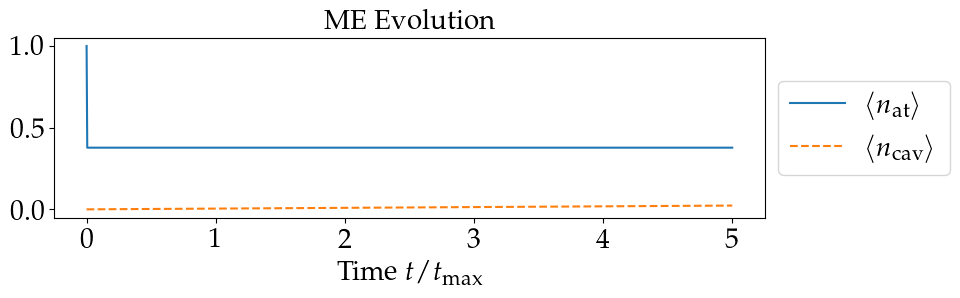

In [147]:
def define_t_max():
    t_max = t_prd_at = t_prd_cav = t_prd_at_cav = t_half_at = t_half_cav = 0

### Determine characteristic times based on the setup
    if g_at != 0:
        t_prd_at = 2 * np.pi / Rabi_at # Period of atomic Rabi oscillations
    if g_cav != 0:
        t_prd_cav = 2 * np.pi / Rabi_cav # Period of cavity Rabi oscillations

    if g_at_cav != 0:
        t_prd_at_cav = 2 * np.pi / Rabi_at_cav # Period of cavity Rabi oscillations

    if "Relax_at" in decay_ops_strg:
        t_half_at = 1 / gamma_0_at # Half-life of atomic relaxation
    if "Relax_cav" in decay_ops_strg:
        t_half_cav = 1 / gamma_0_cav # Half-life of cavity relaxation

    all_times = [t_half_at, t_half_cav, t_prd_at, t_prd_cav, t_prd_at_cav]
    print(all_times)

### Clear selection of t_max based on the setup
    non_zero_values = [val for val in all_times if val > 0]
    print(non_zero_values)

    t_max = sum(non_zero_values) / len(non_zero_values) if non_zero_values else 0
    print("t_{max} = ", t_max)
    return t_max

t_max = define_t_max()
if t_max == 0: t_max = 1

solver_strg = ( # which solvers to use
#    "brme",
    "me",
#    "heom"
)


### Define time arrays for evolution
times = np.linspace(0, 5 * t_max, 1000)

default_options = {
    "store_states": True,
    "progress_bar": "enhanced",
    "rtol": 1e-5,
    "atol": 1e-5,
    "nsteps": 15000, # ¿only? for heom?
    "method": "vern9", # ¿only? for heom?
}

### Compute the evolution based on the selected cases
result_brme = result_me = result_heom = None

if "brme" in solver_strg:
    result_brme = brmesolve(
        H_total,
        psi_ini,
        times,
        e_ops=e_ops_list,
#        a_ops=a_ops_list,
        options=default_options,
    )

if "me" in solver_strg:
    result_me = mesolve(
        H_total,
        psi_ini,
        times,
        e_ops=e_ops_list,
        c_ops=c_ops_list,
        options=default_options,
    )

if "heom" in solver_strg:
    if not decay_ops_strg:
        pass  # Skip this "heom" part if no decay operators are specified
    else:
        # Define the HEOM solver with the provided environment and parameters
        HEOM_dlbath = HEOMSolver(
            L_total, 
            envs, 
            max_depth=max_depth, 
            options=default_options
        )
        
        # Run the HEOM solver and store the result
        result_heom = HEOM_dlbath.run(
            ket2dm(psi_ini), 
            times, 
            e_ops=e_ops_list
        )

# =============================
# PLOT EVOLUTION
# =============================
plt.figure(figsize=(10, 8))

### Plot result_brme if applicable
if result_brme:
    plt.subplot(3, 1, 1)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_brme.times) / t_max,
            result_brme.expect[i],
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'BRME Evolution')

### Plot result_me if applicable
if result_me:
    plt.subplot(3, 1, 2)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_me.times) / t_max,
            result_me.expect[i],
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'ME Evolution')

### Plot result_me if applicable
if result_heom:
    plt.subplot(3, 1, 3)
    for i, e_op in enumerate(e_ops_list):
        plt.plot(
            np.array(result_heom.times) / t_max,
            (result_heom.expect[i]),
            label=e_ops_labels[i],
            linestyle=['solid', 'dashed', 'dashdot', 'dotted'][i % 4],  # Alternate line styles
            color=f'C{i}',  # Use distinct colors
        )
    plt.xlabel(r'Time $t / t_{\text{max}}$')
    plt.title(r'HEOM Evolution')

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


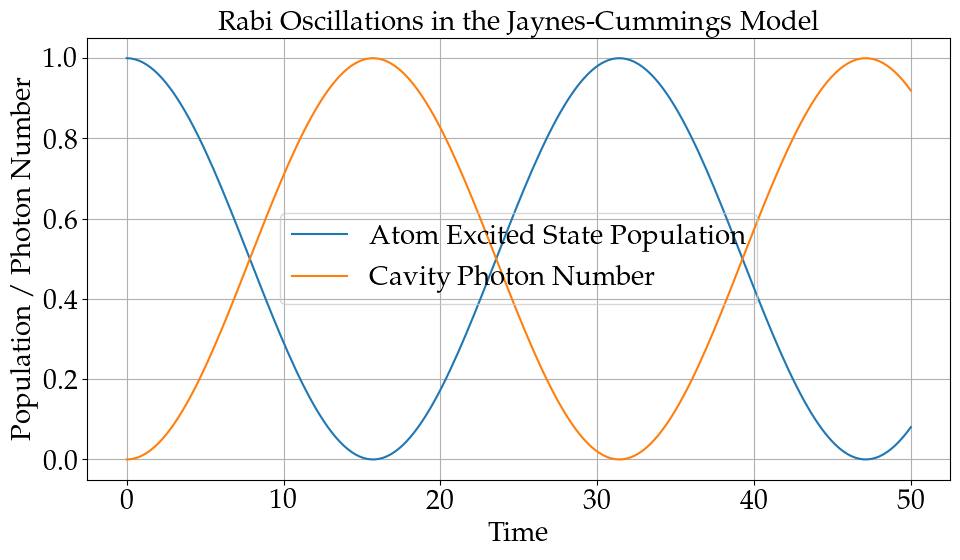

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import (omega_a
    Qobj,
    tensor,
    destroy,
    sigmaz,
    sigmap,
    sigmam,
    expect,
    mesolve,
    basis,
    identity,
)

# Define the system parameters
omega_a = 1.0  # Atomic transition frequency
omega_c = 1.0  # Cavity mode frequency
g = 0.1        # Coupling strength
kappa = 0.0    # Cavity field decay rate (for closed system, set to 0)
gamma = 0.0    # Atomic decay rate (for closed system, set to 0)
n_photons = 0  # Initial number of photons in the cavity
N_cavity_lvls = 4          # Number of cavity levels 

# Create the necessary operators
a = destroy(N_cavity_lvls)  # Annihilation operator for the cavity mode
sigma_z = sigmaz()
sigma_p = sigmap()
sigma_m = sigmam()
I_atom = identity(2)
I_cavity = identity(N_cavity_lvls)

# Construct the Jaynes-Cummings Hamiltonian
H = (omega_c * tensor(a.dag() * a, I_atom) +
     omega_a * tensor(I_cavity, (sigma_z + identity(2)) / 2) +  # Atomic energy
     g * (tensor(a.dag(), sigma_m) + tensor(a, sigma_p)))      # Interaction

# Initial state: atom in the excited state, cavity in the vacuum state
psi0 = tensor(basis(N_cavity_lvls, n_photons), basis(2, 0))

# Time evolution parameters
times = np.linspace(0, 50, 200)

# Operators to measure
a_dag_a = tensor(a.dag() * a, I_atom)  # Photon number operator
sigma_z_op = tensor(I_cavity, sigma_z)   # Atomic inversion operator

# Solve the Master Equation (for open systems) or Schrödinger Equation (for closed)
# Here, we assume a closed system, so we use mesolve with no collapse operators.
# If you want to include decay, add [np.sqrt(kappa) * a, np.sqrt(gamma) * sigma_m]
# to the c_ops argument.
result = mesolve(H, psi0, times, [], [a_dag_a, sigma_z_op])

# Extract expectation values
photon_number = result.expect[0]
atomic_inversion = result.expect[1]

# Calculate the excited state population from atomic inversion
excited_population = (atomic_inversion + 1) / 2

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(times, excited_population, label='Atom Excited State Population')
ax.plot(times, photon_number, label='Cavity Photon Number')
ax.set_xlabel('Time')
ax.set_ylabel('Population / Photon Number')
ax.set_title('Rabi Oscillations in the Jaynes-Cummings Model')
ax.legend()
ax.grid(True)
plt.show()

In [77]:
rho1, rho2 = result_brme.states[-1], result_me.states[-1]
F = fidelity(rho1, rho2)
print(f"Fidelity: {F}")

Fidelity: 0.9986302882788708


/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)


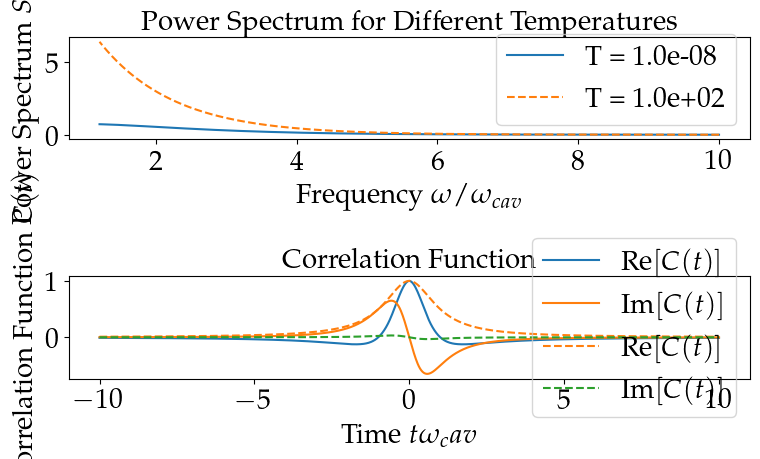

In [ ]:
# =============================
# PLOT BATH MODEL OVER FREQUENCIES AND TIMES
# =============================
cutoff, eta = 10, .1
temperatures = [1e-8, 1e2]
num_points   = 1000
frequencies  = np.linspace(10 * cutoff, 1.2 * cutoff, num_points)  # Frequency range for the plot
times        = np.linspace(-10 / cutoff, 10 / cutoff, num_points)   # Time range for the plot
args = {"eta": eta, "cutoff": cutoff, "s": 1.0}
#args = {"lambda": eta * cutoff / 2, "cutoff": cutoff}

plt.figure(figsize=(8, 5))

### Plot power spectrum
plt.subplot(2, 1, 1)
for Temp in temperatures:
    # Update the bath model for the current temperature
    env = OhmicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, args),
        wMax=10 * cutoff,
        T=Temp
    )
    plt.plot(
        frequencies / cutoff,
        [env.power_spectrum(w) for w in frequencies],
        label=f"T = {Temp:.1e}",
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
        color=f'C{temperatures.index(Temp)}'
    )
plt.xlabel(r'Frequency $\omega / \omega_{cav}$')
plt.ylabel(r'Power Spectrum $S(\omega)$')
plt.title(r"Power Spectrum for Different Temperatures")
plt.legend()

### Plot correlation function
plt.subplot(2, 1, 2)
for Temp in temperatures:
    # Update the bath model for the current temperature
    env = OhmicEnvironment.from_spectral_density(
        lambda w: spectral_density_func_ohmic(w, args),
        wMax=10 * cutoff,
        T=Temp
    )
    correlation_vals = [env.correlation_function(t) for t in times] # Get correlation values
    max_abs_val       = np.max(np.abs(correlation_vals)) # Normalize by maximum absolute value
    plt.plot(
        times * cutoff,
        np.real(correlation_vals) / max_abs_val,
        label=r"$\mathrm{Re}[C(t)]$",
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
        color=f'C{temperatures.index(Temp)}'
    )
    plt.plot(
        times * cutoff,
        np.imag(correlation_vals) / max_abs_val,
        label=r"$\mathrm{Im}[C(t)]$",
        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
        color=f'C{(temperatures.index(Temp) + 1) % 4}'
    )
#    plt.plot(
#        times * cutoff,
#        np.abs(correlation_vals) / max_abs_val,
##        label=r"$|C(t)|$",
#        linestyle=['solid', 'dashed', 'dashdot', 'dotted'][temperatures.index(Temp) % 4],
#        color=f'C{(temperatures.index(Temp) + 2) % 4}'
#    )
plt.xlabel(r'Time $t \omega_cav$')
plt.ylabel(r'Correlation Function $C(t)$')
plt.title(r"Correlation Function")
plt.legend(loc = "center right")

plt.tight_layout()
plt.show()

In [ ]:
#########SOME TEST approximate correlation fucntion baths to be used in heom
### Not used anymore, just for testing
 
#env = DrudeLorentzBath(SM_op, gamma_0_at * cutoff / 2, cutoff, Temp, Nk)
#solver = HEOMSolver(H_total, env, max_depth=max_depth, options=default_options)


env = OhmicEnvironment(T=Temp, alpha=gamma_0_at, wc=cutoff, s=1)
# Fit the correlation function with three exponential terms
times_fit = np.linspace(0, 3 / cutoff, 100)
approx_env, info = env.approx_by_cf_fit(times_fit, target_rsme=None, Nr_max=6, Ni_max=6, maxfev=1e6) # potentially add a guess

plt.plot(times_fit, np.real(env.correlation_function(times_fit)), label='Real part (analytic)')
plt.plot(times_fit, np.real(approx_env.correlation_function(times_fit)), '--', label='Real part (fit)')

plt.plot(times_fit, np.imag(env.correlation_function(times_fit)), label='Imag part (analytic)')
plt.plot(times_fit, np.imag(approx_env.correlation_function(times_fit)), '--', label='Imag part (fit)')

plt.xlabel('Time')
plt.ylabel('Correlation function')
plt.tight_layout()
plt.legend()

times_fit = np.linspace(0, 3 / cutoff, 200)
env_0 = env_2.approx_by_cf_fit(tlist=times_fit, Nr_max=20, full_ansatz=True, maxfev=10000)
#######################################################################################################################################################################
cf = [env_2.correlation_function(t) for t in times_fit]
plt.plot(times_fit, [c.real for c in cf], label="Re(CF)")
plt.plot(times_fit, [c.imag for c in cf], label="Im(CF)")
plt.legend()
plt.show()
#######################################################################################################################################################################
Nk = 2
lambda_ = gamma_0_at
env_1 = DrudeLorentzBath(SX_op, lam=lambda_ * gamma_0_at / 2, gamma=cutoff, T=Temp, Nk=Nk) # decay
# -> Problem: temperature is not added!
# -> Problem: gives totally absurd spectral_density
env_2 = OhmicEnvironment(T=Temp, alpha=gamma_0_at, wc=cutoff, s=1)
env_3 = DrudeLorentzEnvironment(lam=lambda_ * gamma_0_at / 2, gamma=cutoff, T=Temp, Nk=Nk) # decay
#env_1 = DrudeLorentzBath.from_environment(env_3, SX_op) # env_3 has to be a approximation!!!!!!!!!!!
#print(dir(env_1))
#print(vars(env_1))
#print(env_1.__dict__)

env_1.T = Temp

omega = np.linspace(-50, 50, 1000)
J1 = [env_1.power_spectrum(w) for w in omega]
J2 = [env_2.power_spectrum(w) for w in omega]
J3 = [env_3.power_spectrum(w) for w in omega]

#J = omega * 2 * lambda_ * cutoff / (cutoff**2 + omega**2)
#plt.plot(omega, J, "r", linewidth=2, label = "DL_eq")

plt.figure(figsize=(10, 8))

### Plot spectral densities
plt.plot(omega, J1 / np.max(np.abs(J1)), label=r"$J_1(\omega)$ (DL Bath)", linestyle='solid', color='C0')
plt.plot(omega, J2 / np.max(np.abs(J2)), label=r"$J_2(\omega)$ (Ohmic)", linestyle='dashed', color='C1')
plt.plot(omega, J3 / np.max(np.abs(J3)), label=r"$J_3(\omega)$ (DL Env)", linestyle='dashdot', color='C2')

plt.xlabel(r"Frequency $\omega$")
plt.ylabel(r"Spectral Density $J(\omega) / \max(J)$")
plt.title(r"Comparison of Spectral Densities")
plt.legend()
plt.tight_layout()
plt.show()
#######################################################################################################################################################################
env_decay_at = DrudeLorentzBath(SM_op + SM_op.dag(), lam=gamma_0_at * cutoff / 2, gamma=cutoff, T=Temp, Nk=Nk) # decay
env_decay_at.T = Temp

a_ops_list = []

a_ops_list.append([
    SM_op + SM_op.dag(), 
    env_1.spectral_density
    ]  # Relaxation operator
)

result_brme = brmesolve(
    H0,
    psi_ini,
    times,
    a_ops=a_ops_list,
    options=opts  # Pass options here
)

NameError: name 'env_2' is not defined

In [ ]:
### HEOM from qutip
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import qutip
from qutip import (
    basis,
    brmesolve,
    destroy,
    expect,
    liouvillian,
    qeye,
    sigmax,
    sigmaz,
    spost,
    spre,
    tensor,
)

from qutip.solver.heom import (
    BosonicBath,
    DrudeLorentzBath,
    DrudeLorentzPadeBath,
    HEOMSolver,
    HSolverDL,
)

%matplotlib inline


def cot(x):
    """Vectorized cotangent of x."""
    return 1.0 / np.tan(x)
def dl_matsubara_params(lam, gamma, T, nk):
    """Calculation of the real and imaginary expansions of the Drude-Lorenz
    correlation functions.
    """
    ckAR = [lam * gamma * cot(gamma / (2 * T))]
    ckAR.extend(
        4
        * lam
        * gamma
        * T
        * 2
        * np.pi
        * k
        * T
        / ((2 * np.pi * k * T) ** 2 - gamma**2)
        for k in range(1, nk + 1)
    )
    vkAR = [gamma]
    vkAR.extend(2 * np.pi * k * T for k in range(1, nk + 1))

    ckAI = [lam * gamma * (-1.0)]
    vkAI = [gamma]

    return ckAR, vkAR, ckAI, vkAI
def dl_corr_approx(t, nk):
    """Drude-Lorenz correlation function approximation.

    Approximates the correlation function at each time t to nk exponents.
    """
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2)) * np.exp(
            -vk * t
        )
    return c
def plot_result_expectations(plots, axes=None):
    """Plot the expectation values of operators as functions of time.

    Each plot in plots consists of (solver_result, measurement_operation,
    color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig
@contextlib.contextmanager
def timer(label):
    """Simple utility for timing functions:

    with timer("name"):
        ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")
# Default solver options:

default_options = {
    "nsteps": 1500,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "method": "vern9",
    "progress_bar": "enhanced",
}


# Defining the system Hamiltonian
eps = 0.5  # Energy of the 2-level system.
Del = 1.0  # Tunnelling term
Hsys = 0.5 * eps * sigmaz()# + 0.5 * Del * sigmax()
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmax()  # coupling operator

# Bath properties:
gamma = 0.5  # cut off frequency
lam = 0.1  # coupling strength
T = 100
beta = 1.0 / T

# HEOM parameters
NC = 5  # cut off parameter for the bath
Nk = 2  # terms in the Matsubara expansion of the correlation function

# Times to solve for
tlist = np.linspace(0, 50, 1000)
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()


def plot_spectral_density():
    """Plot the Drude-Lorentz spectral density"""
    w = np.linspace(0, 5, 1000)
    J = w * 2 * lam * gamma / (gamma**2 + w**2)

    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
    axes.plot(w, J, "r", linewidth=2)
    axes.set_xlabel(r"$\omega$", fontsize=28)
    axes.set_ylabel(r"J", fontsize=28)


plot_spectral_density()

options = {**default_options}

#In practice, one would not perform this laborious expansion for the Drude-Lorentz correlation function, because QuTiP already has a class, DrudeLorentzBath, that can construct this bath for you. Nevertheless, knowing how to perform this expansion will allow you to construct your own baths for other spectral densities.

#Below we show how to use this built-in functionality:

# Compare to built-in Drude-Lorentz bath:

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    # HEOM_dlbath = HEOMSolver(Hsys, bath, NC, options=options)
    
    _, terminator = bath.terminator()
    Ltot = liouvillian(Hsys) + terminator
    HEOM_dlbath = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlbath = HEOM_dlbath.run(rho0, tlist)  # normal  115
plot_result_expectations(
    [
        (result_dlbath, P11p, "b", "P11 (DrudeLorentzBath)"),
        (result_dlbath, P12p, "r", "P12 (DrudeLorentzBath)"),
        (result_dlbath, P22p, "g", "P22 (DrudeLorentzBath)"),
    ]
);

In [ ]:
# Compare to legacy class:

# The legacy class performs the above collation of coefficients automatically,
# based upon the parameters for the Drude-Lorentz spectral density.

with timer("RHS construction time"):
    HEOMlegacy = HSolverDL(H0, Q, lam, T, NC, Nk, gamma, options=options)

with timer("ODE solver time"):
    resultLegacy = HEOMlegacy.run(rho0, tlist)  # normal  115

plot_result_expectations(
    [
        (resultLegacy, P11p, "b", "P11 Legacy"),
        (resultLegacy, P12p, "r", "P12 Legacy"),
    ]
);

# Compare to built-in Drude-Lorentz bath:

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    HEOM_dlbath = HEOMSolver(H0, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlbath = HEOM_dlbath.run(rho0, tlist)  # normal  115

    plot_result_expectations(
    [
        (result_dlbath, P11p, "b", "P11 (DrudeLorentzBath)"),
        (result_dlbath, P12p, "r", "P12 (DrudeLorentzBath)"),
    ]
);

In [ ]:
# Compare to legacy class:

# The legacy class performs the above collation of coefficients automatically,
# based upon the parameters for the Drude-Lorentz spectral density.

with timer("RHS construction time"):
    HEOMlegacy = HSolverDL(H0, Q, lam, T, NC, Nk, gamma, options=options)

with timer("ODE solver time"):
    resultLegacy = HEOMlegacy.run(rho0, tlist)  # normal  115

plot_result_expectations(
    [
        (resultLegacy, P11p, "b", "P11 Legacy"),
        (resultLegacy, P12p, "r", "P12 Legacy"),
    ]
);

In [ ]:
def plot_correlation_expansion_divergence():
    """We plot the correlation function with a large number of Matsubara terms
    to show that the real part is slowly diverging at t = 0.
    """
    t = np.linspace(0, 2, 100)

    # correlation coefficients with 15k and 2 terms
    corr_15k = dl_corr_approx(t, 15_000)
    corr_2 = dl_corr_approx(t, 2)

    fig, ax1 = plt.subplots(figsize=(12, 7))

    ax1.plot(
        t, np.real(corr_2), color="b", linewidth=3, label=r"Mats = 2 real"
    )
    ax1.plot(
        t, np.imag(corr_2), color="r", linewidth=3, label=r"Mats = 2 imag"
    )
    ax1.plot(
        t, np.real(corr_15k), "b--", linewidth=3, label=r"Mats = 15000 real"
    )
    ax1.plot(
        t, np.imag(corr_15k), "r--", linewidth=3, label=r"Mats = 15000 imag"
    )

    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$C$")
    ax1.legend()


plot_correlation_expansion_divergence();

In [ ]:
# Run HEOM solver and include the Ishizaki-Tanimura terminator

# Notes:
#
# * when using the built-in DrudeLorentzBath, the terminator (L_bnd) is
#   available from bath.terminator().
#
# * in the legacy HSolverDL function the terminator is included automatically
#   if the parameter bnd_cut_approx=True is used.

op = -2 * spre(Q) * spost(Q.dag()) + spre(Q.dag() * Q) + spost(Q.dag() * Q)

approx_factr = (2 * lam / (beta * gamma)) - 1j * lam

approx_factr -= lam * gamma * (-1.0j + cot(gamma / (2 * T))) / gamma
for k in range(1, Nk + 1):
    vk = 2 * np.pi * k * T

    approx_factr -= (4 * lam * gamma * T * vk / (vk**2 - gamma**2)) / vk

L_bnd = -approx_factr * op

Ltot = -1.0j * (spre(H0) - spost(H0)) + L_bnd
Ltot = liouvillian(H0) + L_bnd

options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)
    HEOMMatsT = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

plot_result_expectations(
    [
        (resultMatsT, P11p, "b", "P11 Mats + Term"),
        (resultMatsT, P12p, "r", "P12 Mats + Term"),
    ]
);


options = {**default_options, "rtol": 1e-14, "atol": 1e-14}

with timer("RHS construction time"):
    bath = DrudeLorentzBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)
    _, terminator = bath.terminator()
    Ltot = liouvillian(H0) + terminator
    HEOM_dlbath_T = HEOMSolver(Ltot, bath, NC, options=options)

with timer("ODE solver time"):
    result_dlbath_T = HEOM_dlbath_T.run(rho0, tlist)
plot_result_expectations(
    [
        (result_dlbath_T, P11p, "b", "P11 Mats (DrudeLorentzBath + Term)"),
        (result_dlbath_T, P12p, "r", "P12 Mats (DrudeLorentzBath + Term)"),
    ]
);


DL = (
    f"2*pi* 2.0 * {lam} / (pi * {gamma} * {beta}) if (w == 0) else "
    f"2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) "
    f"* ((1/(exp((w) * {beta})-1))+1)"
)
options = {**default_options}

with timer("ODE solver time"):
    resultBR = brmesolve(
        H0, rho0, tlist, a_ops=[[sigmaz(), DL]], options=options
    )


plot_result_expectations(
    [
        (resultMats, P11p, "b", "P11 Mats"),
        (resultMats, P12p, "r", "P12 Mats"),
        (resultMatsT, P11p, "b--", "P11 Mats + Term"),
        (resultMatsT, P12p, "r--", "P12 Mats + Term"),
        (resultBR, P11p, "g--", "P11 Bloch Redfield"),
        (resultBR, P12p, "g--", "P12 Bloch Redfield"),
    ]
);